<a href="https://colab.research.google.com/github/etuckerman/SOCOTEC/blob/main/SOCOTEC_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU found!")


GPU: NVIDIA A100-SXM4-40GB


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
import torch

# Enable mixed precision for faster computations on A100
torch.set_default_dtype(torch.float16)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True


In [4]:
%%capture
!pip install llama_parse huggingface_hub langchain chromadb nest_asyncio langchain-community unstructured langchain-huggingface gradio

In [5]:
!pip install faiss-gpu-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.5 MB/s eta 0:00:00


In [6]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [7]:
!nvidia-smi


Fri Jan 17 23:36:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              47W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# RAG PIPELINE

# Loading and Preprocessing

In [8]:
# import nest_asyncio
# from llama_parse import LlamaParse

# # Apply nest_asyncio to handle the event loop
# nest_asyncio.apply()

# ### BASIC PARSING
# # # Initialize the LlamaParse parser with optimized parsing instructions
# # parser = LlamaParse(
# #     api_key="*HIDDEN*",
# #     result_type="markdown",  # Retain markdown format for structured output
# #     language="en",  # Set to English since the IBC is in English
# #     verbose=True,  # Enable detailed logs to monitor parsing performance
# #     is_formatting_instruction=True,  # Preserve formatting for context retrieval
# #     parsing_instruction="""
# #         Extract the following key elements from the document:
# #         1. Chapter titles and their numbers.
# #         2. Section headings and subheadings with their corresponding numbers.
# #         3. Key definitions and terms listed in the document.
# #         4. Detailed descriptions of occupancy classifications, fire-resistance requirements, and structural design criteria.
# #         5. All tables and their captions, including their associated data.
# #         6. Any reference codes, figures, or diagrams mentioned in the text.
# #         Format the extracted data in a structured and readable manner, preserving markdown styling for clarity (e.g., **bold** headings, bullet points for lists, etc.).
# #     """
# # )

# ### OPTIMISED PARSING TEST [currently costs 30$ so i cancelled it]
# # Initialize the LlamaParse parser with optimized parameters
# parser = LlamaParse(
#     api_key="*HIDDEN*",
#     is_remote=False,  # Processing locally for faster iterations
#     verbose=True,  # Keep verbose for detailed logs
#     show_progress=True,  # Show progress for better tracking
#     language="en",  # Document language is English
#     split_by_page=True,  # Process document page by page for modularity
#     result_type="markdown",  # Export as markdown for better structuring
#     max_timeout=3000,  # Increase timeout for processing large documents
#     num_workers=6,  # Utilize 6 workers for concurrent processing
#     parsing_instruction=(
#         "Extract all critical information, including definitions, tables, figures, and important text "
#         "relevant to occupancy classifications, construction types, fire-resistance requirements, "
#         "design loads, and any other regulations. Focus on sections that may aid in answering queries."
#     ),
#     structured_output=False,  # Output as plain markdown, structured parsing is unnecessary here
#     annotate_links=True,  # Annotate links for better context during retrieval
#     auto_mode=True,  # Enable auto mode to trigger optimizations for certain elements
#     auto_mode_trigger_on_table_in_page=True,  # Prioritize tables (highly structured info)
#     auto_mode_trigger_on_image_in_page=True,  # Include charts/diagrams for completeness
#     disable_ocr=False,  # Allow OCR for text in non-standard formats
#     extract_charts=True,  # Include chart data in the parsed output
#     extract_layout=False,  # Skip layout info, focusing purely on content
#     premium_mode=True,  # Enable premium processing for improved accuracy
#     page_separator="\n\n---\n\n",  # Separate pages clearly for retrieval
#     max_pages=None,  # Process the entire document
#     continuous_mode=False,  # Avoid continuous mode; keep pages distinct
# )


# # Parse the syllabus document
# parsed_documents = parser.load_data("/content/IBC.pdf")

# # Save the parsed results to a markdown or any preferred format
# with open('IBC.md', 'w') as f:
#     for doc in parsed_documents:
#         f.write(doc.text + '\n')


# Embedding and Vector Store setup

In [9]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [10]:
torch.cuda.empty_cache()


In [11]:
!nvidia-smi


Fri Jan 17 23:36:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              47W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [12]:
from transformers import AutoTokenizer, AutoModel
import faiss
import torch
import numpy as np
from langchain.document_loaders import UnstructuredMarkdownLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline

# Step 1: Load the parsed markdown document
loader = UnstructuredMarkdownLoader("IBC.md")
docs = loader.load()

# Step 2: Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=100)
texts = text_splitter.split_documents(docs)

# Step 3: Load the BGE model for embeddings
model_name = "BAAI/bge-m3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)

# Move the model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = embedding_model.to(device)

# Adjust the embedding generation code
def get_embeddings(texts, model, tokenizer):
    """
    Generate embeddings for a list of texts using the BGE model on GPU.
    """
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        # Mean pooling to get fixed-size embeddings
        embeddings = outputs.last_hidden_state.mean(dim=1)

    return embeddings.cpu().numpy()  # Move the result back to CPU for further processing


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

In [13]:

# Generate embeddings for the document chunks
corpus_embeddings = get_embeddings([doc.page_content for doc in texts], embedding_model, tokenizer)

# Step 4: Initialize a FAISS vector store
embedding_dim = corpus_embeddings.shape[1]  # Dimension of embeddings
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance for similarity search

# Convert embeddings to np.float32 and ensure contiguous memory layout
corpus_embeddings = corpus_embeddings.astype(np.float32)
#This line ensures the embeddings are in the correct data type.
corpus_embeddings = np.ascontiguousarray(corpus_embeddings)
#This line ensures the embeddings are in a contiguous memory layout.


# Add embeddings to the vector store
index.add(corpus_embeddings)

def retrieve_documents(query, k=2):
    """
    Retrieve the top-k most similar documents for a given query.
    """
    query_embedding = get_embeddings([query], embedding_model, tokenizer)
    distances, indices = index.search(query_embedding, k)
    results = [texts[i].page_content for i in indices[0]]
    return results

# Step 5: Load the Qwen Model for Text Generation
qwen_pipe = pipeline(
    "text-generation",
    model="Qwen/Qwen2.5-7B",
    tokenizer="Qwen/Qwen2.5-7B",
    device=0  # Use GPU
)
qwen_llm = HuggingFacePipeline(pipeline=qwen_pipe)


config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
# Step 6: Define the Prompt Template
prompt = PromptTemplate(
    input_variables=["context", "query"],
    template=(
        "<|im_start|>user\n"
        "You are Qwen, created by Alibaba Cloud. You are a helpful assistant. "
        "You have extensive knowledge of the IBC 2018 International Building Code. "
        "Answer the following query based on your knowledge of the IBC, as if you are already familiar with the content. "
        "Do not mention or reference any specific document or context. Just provide a direct and concise answer. \n"
        "Query: {query}\n"
        "<|im_end|>\n\n"
        "<|im_start|>assistant\n"
    ),
)


In [15]:
# import torch
# from transformers import pipeline
# from langchain.document_loaders import UnstructuredMarkdownLoader
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.prompts import PromptTemplate

# # Define the prompt template for summarization
# def summarize_chunk(chunk, llm, max_new_tokens=300):
#     """
#     Summarize the following text in bullet points. Ensure the summary is accurate, concise, and includes all key information.
#     Avoid omitting important details or using unnecessary phrases.
#     """
#     prompt = (
#         "Provide a concise summary of the following text in bullet points. Be sure to include all essential information "
#         "without leaving out key details. Avoid unnecessary explanations or introductory phrases.\n\n"
#         f"{chunk}\n\n"
#         "Summary:"
#     )

#     response = llm(prompt, max_new_tokens=max_new_tokens, truncation=True)
#         # Ensure the model generates the summary content properly
#     summary = response[0]["generated_text"]

#     # Strip any potential leading 'Summary:' text
#     if "Summary:" in summary:
#         summary = summary.split("Summary:")[-1].strip()

#     return summary

# # Load the parsed markdown document
# loader = UnstructuredMarkdownLoader("IBC.md")
# docs = loader.load()

# # Split documents into chunks
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=100)
# texts = text_splitter.split_documents(docs)

# # Summarize each chunk and save to a new list
# summarized_chunks = []
# for doc in texts:
#     summarized_chunk = summarize_chunk(doc.page_content, qwen_pipe)
#     summarized_chunks.append(summarized_chunk)

#     # Print each summarized chunk after it is generated
#     print(f"Summary of Chunk {len(summarized_chunks)}:\n{summarized_chunk}\n\n---\n")

# # Save the summarized chunks to a .md file
# with open('summarized_chunks.md', 'w') as f:
#     for idx, summary in enumerate(summarized_chunks):
#         f.write(f"### Summary of Chunk {idx + 1}\n\n{summary}\n\n---\n\n")

# print("Summarized chunks have been saved to 'summarized_chunks.md'.")


In [16]:
# # Save the summarized chunks to a .md file without headers
# with open('summarized_chunks_rag.md', 'w') as f:
#     for idx, summary in enumerate(summarized_chunks):
#         f.write(f"{summary}\n\n---\n\n")  # Only save the summary without the header


In [17]:
import gradio as gr

In [18]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_documents(query, k=2, device="cuda"):
    """
    Retrieve the top-k most similar documents for a given query.
    """
    # Move the model to the correct device (GPU or CPU)
    embedding_model.to(device)

    # Tokenize the query
    query_embedding = tokenizer(query, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        # Generate embeddings from the model
        query_embedding = embedding_model(**query_embedding).last_hidden_state.mean(dim=1)  # Get embeddings

    query_embedding = query_embedding.cpu().numpy().astype(np.float32)  # Ensure the embeddings are on CPU before passing to FAISS

    # Perform similarity search in the FAISS index
    distances, indices = index.search(query_embedding, k)
    results = [texts[i] for i in indices[0]]  # Retrieve the corresponding documents

    # Calculate cosine similarity between the query embedding and retrieved document embeddings
    document_embeddings = [
        embedding_model(**tokenizer(doc.page_content, return_tensors="pt", padding=True, truncation=True).to(device)).last_hidden_state.mean(dim=1).detach().cpu().numpy()
        for doc in results
    ]
    similarities = [cosine_similarity(query_embedding, doc_emb).flatten()[0] for doc_emb in document_embeddings]

    return results, similarities

# Define the function that will process the query
def query_rag_system(query, device="cuda"):
    # Retrieve the documents relevant to the query and their similarity scores
    retrieved_docs, similarities = retrieve_documents(query, device=device)

    # Extract the text content from Document objects and concatenate them to form the context
    context = " ".join([doc.page_content for doc in retrieved_docs])

    # Debugging: print the context and similarity scores
    print(f"Context for query '{query}':\n{context}\n")
    print(f"Similarity scores for retrieved documents: {similarities}")

    # Format the context and query for the model
    formatted_input = prompt.format(context=context, query=query)

    # Get the model's response
    model_response = qwen_llm(formatted_input)

    # Return both the model's response and the similarity scores
    return f"Model Response:\n{model_response}\n\nSimilarity Scores: {similarities}"

# Create Gradio interface
interface = gr.Interface(
    fn=query_rag_system,  # Function to handle user input and query the RAG system
    inputs=gr.Textbox(label="Enter your query", placeholder="Ask a question..."),  # User input field
    outputs=gr.Textbox(label="RAG System Answer", lines=20),  # Output the response
    live=True,  # Optional: update in real-time
    title="RAG Query Interface",
    description="Enter a question, and the system will provide an answer based on the retrieved context."
)

# Launch the Gradio interface
interface.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9c36221725d003ce6d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Context for query '1. What are the minimum requirements for egress width in a building?':
Exceptions: 1. Foyers, lobbies or reception rooms constructed as required for corridors shall not be construed as intervening rooms. 2. Enclosed elevator lobbies as permitted by Item 1 of Section 1016.2 shall not be construed as intervening rooms.

SECTION 1021

EGRESS BALCONIES

1021.1 General.

Balconies used for egress purposes shall conform to the same requirements as corridors for minimum width, required capacity, headroom, dead ends and projections.

1021.2 Wall separation.

Exterior egress balconies shall be separated from the interior of the building by walls and opening protectives as required for corridors.

Exception: Separation is not required where the exterior egress balcony is served by not less than two stairways and a dead-end travel condition does not require travel past an unprotected opening to reach a stairway.

1021.3 Openness.

The long side of an egress balcony shall be not

<ipython-input-18-fa6b3e368ca4>:50: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  model_response = qwen_llm(formatted_input)


Context for query '1. What are the minimum requirements for egress width in a building':
Exceptions: 1. Foyers, lobbies or reception rooms constructed as required for corridors shall not be construed as intervening rooms. 2. Enclosed elevator lobbies as permitted by Item 1 of Section 1016.2 shall not be construed as intervening rooms.

SECTION 1021

EGRESS BALCONIES

1021.1 General.

Balconies used for egress purposes shall conform to the same requirements as corridors for minimum width, required capacity, headroom, dead ends and projections.

1021.2 Wall separation.

Exterior egress balconies shall be separated from the interior of the building by walls and opening protectives as required for corridors.

Exception: Separation is not required where the exterior egress balcony is served by not less than two stairways and a dead-end travel condition does not require travel past an unprotected opening to reach a stairway.

1021.3 Openness.

The long side of an egress balcony shall be not 

In [22]:
import time
from sklearn.metrics.pairwise import cosine_similarity

# List of example questions to ask
questions = [
    "What are the minimum requirements for egress width in a building?",
    "How does the IBC define the 'exit access' component of a means of egress?",
    "What are the requirements for exit signage in high-rise buildings?",
    "What are the requirements for wind load calculations?",
    "How does the IBC address seismic design categories?",
    "What is the importance of load combinations in structural design?",
    "What are the fire-resistance rating requirements for walls separating different occupancies?",
    "How does the IBC regulate fire sprinkler systems in commercial buildings?",
    "What is the maximum allowable travel distance to an exit in a Group B (Business) occupancy?",
    "What are the IBC accessibility requirements for wheelchair spaces in assembly areas?",

]

# Function to calculate metrics for each question
def query_rag_system_with_metrics(query, device="cuda"):
    # Start the timer to measure query processing time
    start_time = time.time()

    # Retrieve the documents relevant to the query and their similarity scores
    retrieved_docs, similarities = retrieve_documents(query, device=device)

    # Calculate the total similarity score for retrieved documents
    total_similarity_score = sum(similarities)

    average_similarity_score = total_similarity_score / len(similarities) if similarities else 0

    # Extract the text content from Document objects and concatenate them to form the context
    context = " ".join([doc.page_content for doc in retrieved_docs])

    # Calculate the time taken for document retrieval
    retrieval_time = time.time() - start_time

    # Debugging: print the context and similarity scores
    #print(f"Context for query '{query}':\n{context}\n")
    print(f"Similarity scores for retrieved documents: {similarities}")

    # Return the results along with the metrics
    return {
        "query": query,
        "retrieved_docs": len(retrieved_docs),  # Number of documents retrieved
        "similarity_scores": similarities,  # List of similarity scores
        "total_similarity_score": total_similarity_score,  # Sum of similarity scores
        "average_similarity_score": average_similarity_score,  # Average similarity score
        "retrieval_time": retrieval_time  # Time taken to retrieve documents
    }

# Process each question and print the results with metrics
for question in questions:
    result = query_rag_system_with_metrics(question)
    print(f"\nMetrics for the query: '{question}'")
    print(f"Number of documents retrieved: {result['retrieved_docs']}")
    print(f"Similarity scores: {result['similarity_scores']}")
    print(f"average_similarity_score : {result['average_similarity_score']}")
    print(f"Document retrieval time: {result['retrieval_time']:.2f} seconds\n")


Similarity scores for retrieved documents: [0.8174798417542934, 0.7945952104559488]

Metrics for the query: 'What are the minimum requirements for egress width in a building?'
Number of documents retrieved: 2
Similarity scores: [0.8174798417542934, 0.7945952104559488]
average_similarity_score : 0.8060375261051211
Document retrieval time: 0.07 seconds

Similarity scores for retrieved documents: [0.748065534405399, 0.7379896207663434]

Metrics for the query: 'How does the IBC define the 'exit access' component of a means of egress?'
Number of documents retrieved: 2
Similarity scores: [0.748065534405399, 0.7379896207663434]
average_similarity_score : 0.7430275775858712
Document retrieval time: 0.07 seconds

Similarity scores for retrieved documents: [0.7918182695021967, 0.7736312885355103]

Metrics for the query: 'What are the requirements for exit signage in high-rise buildings?'
Number of documents retrieved: 2
Similarity scores: [0.7918182695021967, 0.7736312885355103]
average_similari

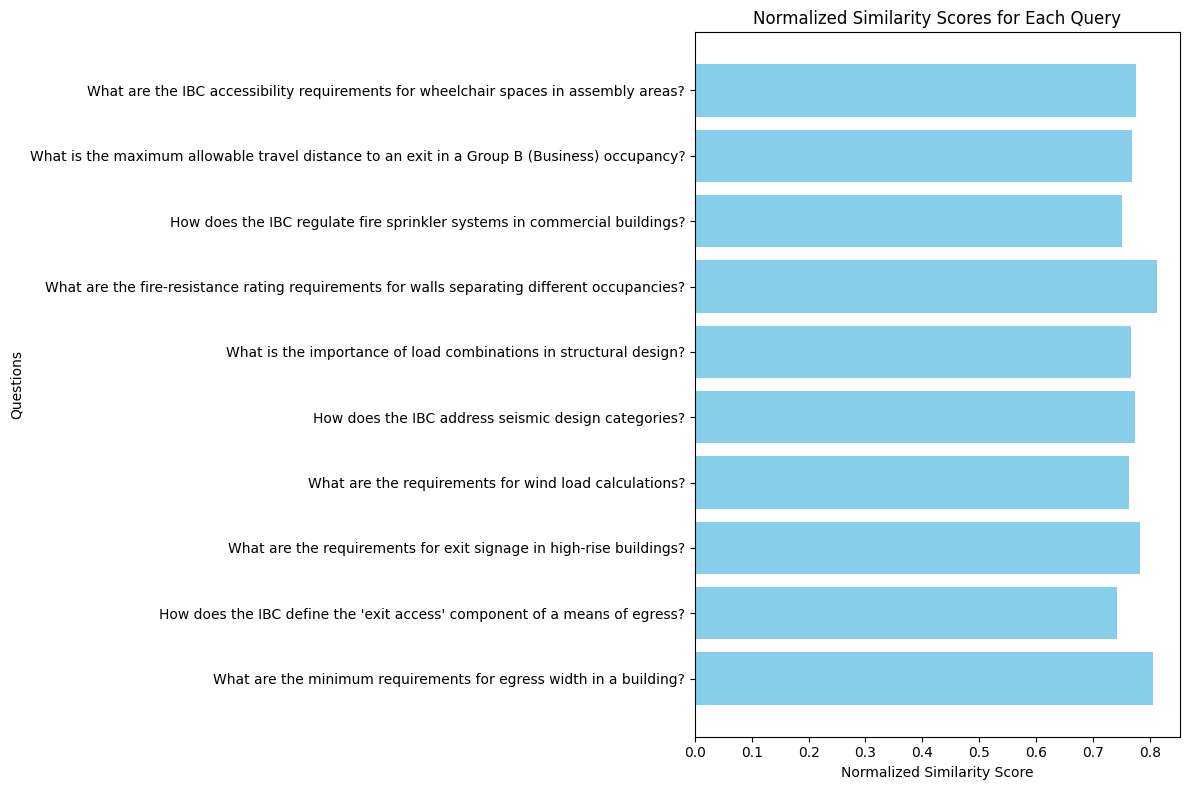

In [20]:
import matplotlib.pyplot as plt

# Function to query the RAG system with metrics and return similarity scores for graphing
def query_rag_system_with_normalized_metrics(query, device="cuda"):
    # Retrieve the documents and their similarity scores
    retrieved_docs, similarities = retrieve_documents(query, device=device)

    # Normalize the total similarity score by dividing by the number of documents
    normalized_similarity_score = sum(similarities) / len(similarities) if similarities else 0
    return query, normalized_similarity_score

# Process each question and store the normalized similarity scores
questions_for_plotting = []
normalized_similarity_scores_for_plotting = []

# Process each question and store the results
for question in questions:
    query, normalized_score = query_rag_system_with_normalized_metrics(question)
    questions_for_plotting.append(query)
    normalized_similarity_scores_for_plotting.append(normalized_score)

# Plotting the normalized similarity scores as a bar chart
plt.figure(figsize=(12, 8))
plt.barh(questions_for_plotting, normalized_similarity_scores_for_plotting, color='skyblue')
plt.xlabel('Normalized Similarity Score')
plt.ylabel('Questions')
plt.title('Normalized Similarity Scores for Each Query')
plt.tight_layout()
plt.show()
